In [1]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from keybert import KeyBERT
import yake
import string
import numpy as np
import datetime

In [2]:
sds_data = pd.read_csv('../data/sds_ds_text.csv')
sds_non_data = pd.read_csv('../data/sds_nds_text.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generating keywords for Data Science Episodes

In [3]:
sds_ds_processed = pd.DataFrame(sds_data.groupby(['episode_number', 'episode_name', 'length_episode', 'class', 'guest_name', 'host_episode', 'episode_year', 'episode_date'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

<IPython.core.display.Javascript object>

In [ ]:
# Remove episode 202 and 546 with no text in episode_split_text
#sds_processed = 
#sds_ds_processed[sds_ds_processed['episode_split_text'] == 'nan']#.reset_index(drop = True)

In [4]:
# Function to clean the text 
def processed_text(text):  
    # Lowercase the text
    text = text.lower()
    # Remove punctuation from the text
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove digits from the text
    text = ''.join(char for char in text if not char.isdigit())
    return text

In [6]:
sds_ds_processed['episode_split_text'].loc[1]

'this is session number two with machine learning expert and entrepreneur hadelin de ponteveswelcome to the superdatascience podcast my name is kirill eremenko data science coach and lifestyle entrepreneur and each week we bring you inspiring people and ideas to help you build your successful career in data science thanks for being here today and now let’s make the complex simplewelcome everyone to a very special edition of the superdatascience podcast and you might say this is only the second episode kirill why is it so special well that is because today i’m bringing you a very good friend of mine hadelin de pontevesand in fact we only met a couple of months ago over a workrelated project but we instantly bonded you know how you get that feeling sometimes when you meet somebody whose values are very similar to yourstheir aspirations and ambitions are very similar to yours and you instantly develop this strong connection and understanding of each other and that’s exactly what happened 

In [5]:
sds_ds_processed['episode_split_text'] = sds_ds_processed['episode_split_text'].apply(processed_text)

In [ ]:
sds_ds_processed

In [ ]:
sds_ds_processed

In [ ]:
sds_ds_processed.info()

In [ ]:
sds_ds_processed['episode_split_text'].loc[400]

In [7]:
sds_ds_processed['episode_keywords'] = None

In [8]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_ds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_ds_processed.at[i, 'episode_keywords'] = keywords

In [9]:
yake_keyword_extractor(sds_ds_processed['episode_split_text'])

In [10]:
sds_ds_processed

,episode_number,episode_name,length_episode,class,guest_name,host_episode,episode_year,episode_date,episode_split_text,episode_keywords
0,1,"Ruben Kogel on Self-Serve Analytics, R vs Pyt...",42,Database,Ruben Kogel,Kirill Eremenko,2016,2016-09-10,this is episode number one with exchemical eng...,"[(data science, 5.201241348387194e-06), (eleme..."
1,2,"Machine Learning, Recommender Systems and the...",51,Machine Learning,Hadelin de Ponteves,Kirill Eremenko,2016,2016-09-14,this is session number two with machine learni...,"[(machine learning machine, 2.506258710542196e..."
2,3,"Defining the Data Problem, Data Science in Ma...",53,Machine Learning,Dr. Wilson Pok,Kirill Eremenko,2016,2016-09-25,this is episode number three with nanophysics ...,"[(data science podcast, 4.651681915765842e-06)..."
3,4,"Data and Strategy, three Pillars of Research ...",60,Data Science,Brendan Hogan,Kirill Eremenko,2016,2016-10-02,this is episode four with business strategy ex...,"[(data scientist role, 4.206800003765128e-06),..."
4,5,"Computer Forensics, Fraud Analytics and knowi...",63,Data Science,Dmitry Korneev,Kirill Eremenko,2016,2016-10-09,this is episode number five with forensics inv...,"[(unstructured data analytics, 7.2255270954093..."
...,...,...,...,...,...,...,...,...,...,...
446,679,"The A.I. and Machine Learning Landscape, with...",94,Artificial Intelligence,George Mathew,Jon Krohn,2023,2023-05-16,this is episode number with george matthew ma...,"[(product market fit, 2.3243289496297082e-06),..."
447,680,Automating Industrial Machines with Data Scie...,30,Data Science,Allegra Alessi,Jon Krohn,2023,2023-05-19,this is episode number with allegra alessi io...,"[(product owner role, 6.017532439633584e-06), ..."
448,681,XGBoost,72,Machine Learning,Matt Harrison,Jon Krohn,2023,2023-05-23,this is episode number with matt harrison man...,"[(xgboost model yeah, 4.032379247073571e-06), ..."
449,682,"Business Intelligence Tools, with Mico Yuk",28,Data Science,Mico Yuk,Jon Krohn,2023,2023-05-26,this is episode number with mico yuk host of ...,"[(yeah yeah yeah, 1.3697862978155252e-06), (da..."


In [11]:
def tuple_extractor(row):
    words = [t[0].replace(" ", "_") for t in row]
    return " ".join(words)

In [12]:
sds_ds_processed['keywords'] = sds_ds_processed['episode_keywords'].apply(tuple_extractor)

In [13]:
sds_ds_processed

,episode_number,episode_name,length_episode,class,guest_name,host_episode,episode_year,episode_date,episode_split_text,episode_keywords,keywords
0,1,"Ruben Kogel on Self-Serve Analytics, R vs Pyt...",42,Database,Ruben Kogel,Kirill Eremenko,2016,2016-09-10,this is episode number one with exchemical eng...,"[(data science, 5.201241348387194e-06), (eleme...",data_science elemental_data_problems science_s...
1,2,"Machine Learning, Recommender Systems and the...",51,Machine Learning,Hadelin de Ponteves,Kirill Eremenko,2016,2016-09-14,this is session number two with machine learni...,"[(machine learning machine, 2.506258710542196e...",machine_learning_machine data_data_science lea...
2,3,"Defining the Data Problem, Data Science in Ma...",53,Machine Learning,Dr. Wilson Pok,Kirill Eremenko,2016,2016-09-25,this is episode number three with nanophysics ...,"[(data science podcast, 4.651681915765842e-06)...",data_science_podcast approach_data_science ’re...
3,4,"Data and Strategy, three Pillars of Research ...",60,Data Science,Brendan Hogan,Kirill Eremenko,2016,2016-10-02,this is episode four with business strategy ex...,"[(data scientist role, 4.206800003765128e-06),...",data_scientist_role research_youre_working sup...
4,5,"Computer Forensics, Fraud Analytics and knowi...",63,Data Science,Dmitry Korneev,Kirill Eremenko,2016,2016-10-09,this is episode number five with forensics inv...,"[(unstructured data analytics, 7.2255270954093...",unstructured_data_analytics data_analytics_tec...
...,...,...,...,...,...,...,...,...,...,...,...
446,679,"The A.I. and Machine Learning Landscape, with...",94,Artificial Intelligence,George Mathew,Jon Krohn,2023,2023-05-16,this is episode number with george matthew ma...,"[(product market fit, 2.3243289496297082e-06),...",product_market_fit large_language_models data_...
447,680,Automating Industrial Machines with Data Scie...,30,Data Science,Allegra Alessi,Jon Krohn,2023,2023-05-19,this is episode number with allegra alessi io...,"[(product owner role, 6.017532439633584e-06), ...",product_owner_role data_scienceoriented_produc...
448,681,XGBoost,72,Machine Learning,Matt Harrison,Jon Krohn,2023,2023-05-23,this is episode number with matt harrison man...,"[(xgboost model yeah, 4.032379247073571e-06), ...",xgboost_model_yeah decision_tree_models book_e...
449,682,"Business Intelligence Tools, with Mico Yuk",28,Data Science,Mico Yuk,Jon Krohn,2023,2023-05-26,this is episode number with mico yuk host of ...,"[(yeah yeah yeah, 1.3697862978155252e-06), (da...",yeah_yeah_yeah data_storytelling_framework ana...


In [14]:
sds_ds_processed.to_csv('../data/sds_ds_keywords.csv', index = False)

## Generating keywords for non-Data Science Episodes

In [15]:
sds_nds_processed = pd.DataFrame(sds_non_data.groupby(['episode_number', 'episode_name', 'length_episode', 'context_episode', 'guest_name', 'host_episode', 'episode_year'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

<IPython.core.display.Javascript object>

In [16]:
sds_nds_processed['episode_split_text'] = sds_nds_processed['episode_split_text'].apply(processed_text)

In [17]:
sds_nds_processed['episode_keywords'] = None

In [18]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_nds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_nds_processed.at[i, 'episode_keywords'] = keywords

In [19]:
yake_keyword_extractor(sds_nds_processed['episode_split_text'])

In [20]:
sds_nds_processed['keywords'] = sds_nds_processed['episode_keywords'].apply(tuple_extractor)

In [22]:
sds_nds_processed

,episode_number,episode_name,length_episode,context_episode,guest_name,host_episode,episode_year,episode_split_text,episode_keywords,keywords
0,22,SEOI PEI – The skin of water listen now,10,Data Science,Kirill Eremenko,Kirill Eremenko,2017,this is episode number and today were kicking...,"[(minute friday sessionshello, 9.7043007419160...",minute_friday_sessionshello thousand_people_li...
1,24,“What are you passionate about?”,5,Data Science,Kirill Eremenko,Kirill Eremenko,2017,this is five minute friday episode number and...,"[(theyre passionate completely, 9.532967431373...",theyre_passionate_completely fantastic_time_co...
2,26,Sweat every day,6,Data Science,Kirill Eremenko,Kirill Eremenko,2017,this is five minute friday episode number swe...,"[(body temperature meaning, 9.127388236232729e...",body_temperature_meaning sweating_releases_end...
3,27,"Career choice, disruptions in finance and app...",62,Uncategorized,Aziz Mamatov,Kirill Eremenko,2017,this is episode number with vice president of...,"[(data science yeah, 3.2346981864497386e-06), ...",data_science_yeah finance_world_interesting ye...
4,28,Pride and humility,5,Data Science,Kirill Eremenko,Kirill Eremenko,2017,this is five minute friday episode number pri...,"[(great accomplishment great, 0.00017971430030...",great_accomplishment_great project_youre_delay...
...,...,...,...,...,...,...,...,...,...,...
226,616,The Four Requirements for Expertise (beyond t...,6,Data Science Career Tips,Jon Krohn,Jon Krohn,2022,this is fiveminute friday on the requirements ...,"[(chess piano tennis, 0.00012765156512494006),...",chess_piano_tennis repeated_timely_feedback cl...
227,618,The Joy of Atelic Activities,4,Life Philosophy Data Science,Jon Krohn,Jon Krohn,2022,this is fiveminute friday on the joy of atelic...,"[(atelic activities include, 0.000101707939323...",atelic_activities_include enriching_life_exper...
228,622,Burnout,24,Business Data Science Productivity Career Tips,Christina Maslach,Jon Krohn,2022,this is episode number with professor christi...,"[(chronic job stressors, 2.249540632751539e-05...",chronic_job_stressors workload_theyre_talking ...
229,640,What I Learned in 2022,37,Data Science,Jon Krohn,Jon Krohn,2022,this is fiveminute friday on what i learned in...,"[(year episode number, 3.7707061236867265e-06)...",year_episode_number machine_learning_company y...


In [23]:
sds_nds_processed.to_csv('../data/sds_nds_keywords.csv', index = False)

### Count Vectorizer and Class-Based Tfidf

In [24]:
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import normalize

In [25]:
sds_ds_keywords = pd.read_csv('../data/sds_ds_keywords.csv')

keywords_per_class = sds_ds_keywords.groupby('class')['keywords'].apply(' '.join).reset_index()

# Rename the columns to match the original code
keywords_per_class = keywords_per_class.rename(columns={'class': 'Class', 'keywords': 'Document'})

<IPython.core.display.Javascript object>

In [28]:
keywords_per_class

,Class,Document
0,Artificial Intelligence,data_science_work governments_data_science sci...
1,"Artificial Intelligence, Deep Learning",kaggle_competitions_basically people_basically...
2,Blockchain,blockchain_yeah_yeah basically_apply_blockchai...
3,Data Science,data_scientist_role research_youre_working sup...
4,"Data Science, Career",data_science_interview super_data_science sql_...
5,"Data Science, Productivity",yeah_yeah_yeah science_machine_learning learni...
6,Data Visualization,learning_data_science data_science_journey dat...
7,Database,data_science elemental_data_problems science_s...
8,Deep Learning,machine_learning_models data_science_machine y...
9,Machine Learning,machine_learning_machine data_data_science lea...


In [ ]:
keywords_per_class

In [29]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [30]:
# Create c-TF-IDF
count = CountVectorizer().fit_transform(keywords_per_class.Document)
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class)).toarray()

In [31]:
# Create bag of words using count vectorizer
count_vectorizer = CountVectorizer().fit(keywords_per_class.Document)
count = count_vectorizer.transform(keywords_per_class.Document)
words = count_vectorizer.get_feature_names_out()

In [32]:
count_vectorizer.vocabulary_

{'data_science_work': 6475,
 'governments_data_science': 11407,
 'science_data_collection': 23570,
 'work_programmers_data': 30218,
 'left_brain_people': 15791,
 'people_indecipherable_things': 19756,
 've_read_bits': 29266,
 'unsupervised_learning_works': 28995,
 'taxpayers': 26826,
 '_money_governments': 5,
 'main_things_today': 16785,
 'show_notes_yeah': 24234,
 'arts_yeah_yay': 1458,
 'yeah_yay_good': 30687,
 'data_analytics_capabilitiesand': 6264,
 'departments_performing_business': 6933,
 'technical_left_brain': 26944,
 'university_studies_interesting': 28938,
 'tax_office_inaudible': 26822,
 'data': 6249,
 'providing_online_services': 21574,
 'good_bacteria_probiotic': 11103,
 'photography_sculpture_painting': 20107,
 'latest_technology_implement': 15533,
 'huge_competitive_edgeon': 12894,
 'lot': 16380,
 'inanimate_objects_anymore': 13518,
 'published_isaac_newton': 21648,
 'work': 30172,
 'subject_matter_experts': 26031,
 'high_low_close': 12515,
 'shen_henry_wang': 24110,
 'b

In [33]:
len(count_vectorizer.vocabulary_)

31155

In [34]:
count.shape

(15, 31155)

In [35]:
word_counts = pd.DataFrame({
    'words': count_vectorizer.get_feature_names_out(),
    'frequency': np.array(count.sum(axis = 0)).flatten()
})
word_counts.sort_values('frequency', ascending = False)

<IPython.core.display.Javascript object>

,words,frequency
6249,data,368
30548,yeah,254
16380,lot,193
27743,time,189
24177,show,176
...,...,...
10769,gdpr_legal_services,1
10768,gdpr_global,1
10767,gdpr,1
10765,gdansk_university,1


In [36]:
word_counts[word_counts['frequency'] < 5]

,words,frequency
0,_affairs,1
1,_capacity_enabling,1
2,_digital,1
3,_guys,1
4,_hands,1
...,...,...
31150,zuckerberg_gray,1
31151,zuckerbergthe_fourth_mentor,1
31152,zurich,1
31153,zurich_in_switzerland,1


In [37]:
# class based tfidf
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class)).toarray()

In [41]:
# find unique words in each class
unique_words_per_class = []
for i, class_docs in enumerate(keywords_per_class.Document):
    tfidf_scores = ctfidf[i]
    unique_word_indices = np.argsort(tfidf_scores)[-50:][::-1]  # index
    unique_words = [words[idx] for idx in unique_word_indices]  # feature name
    unique_words_per_class.append(unique_words)

class_unique_50 = pd.DataFrame({'Class': keywords_per_class.Class, 'unique_Words': unique_words_per_class})


<IPython.core.display.Javascript object>

In [42]:
class_unique_50

,Class,unique_Words
0,Artificial Intelligence,"[agi, capacity, optimal, tasks, influential_sc..."
1,"Artificial Intelligence, Deep Learning","[atari_video_games, deep_learning_illustrated,..."
2,Blockchain,"[funds_check_youre, interactive_data_apps, cal..."
3,Data Science,"[running, minute_friday_episode, time_happy, p..."
4,"Data Science, Career","[facilitates_team_productivity, interested_in_..."
5,"Data Science, Productivity","[matrix, todays_episode_mariya, lot_hashtag_st..."
6,Data Visualization,"[chart, qlik, good_day, slack_channel, andy, p..."
7,Database,"[flow, tend_to_gravitate, ruben, understand_ha..."
8,Deep Learning,"[real_time_quality, run_today, learning_data_e..."
9,Machine Learning,"[project_youre_working, gpus, gradient_boostin..."


In [43]:
class_unique_50['unique_Words'].loc[0]

['agi',
 'capacity',
 'optimal',
 'tasks',
 'influential_scientists',
 'billion_model_parameters',
 'llama',
 'authors',
 'bert',
 'forward_to_enjoying',
 'big_picture',
 'extremely_complex',
 'robotics',
 'dolly',
 'key_natural',
 'competitive',
 'crucial',
 'yann',
 'show_notes_called',
 'air',
 'ceos',
 'stay_on_top',
 'real_world_object',
 'highly_encourage',
 'pairs',
 'dont_trust',
 'rlhf_reinforcement_learning',
 'machine_learning_project',
 'khai',
 'hundred_percent',
 'box',
 'benchmark',
 'dark_web',
 'original',
 'friday_with_part',
 'human_decision_making',
 'dall',
 'care',
 'violent_pornographic_images',
 'enjoyed_this_fiveminute',
 'endless',
 'years_ago_back',
 'hugging',
 'uniform_bar_exam',
 'similar_kind',
 'universities_provide_access',
 'graph',
 'suggest',
 'real_world_applications',
 'rlhf']

In [44]:
class_unique_50['Class'].unique()

array(['Artificial Intelligence',
       'Artificial Intelligence, Deep Learning', 'Blockchain',
       'Data Science', 'Data Science, Career',
       'Data Science, Productivity', 'Data Visualization', 'Database',
       'Deep Learning', 'Machine Learning',
       'Machine Learning, Artificial Intelligence',
       'Machine Learning, Artificial Intelligence, Deep Learning',
       'Machine Learning, Deep Learning', 'Programming',
       'Programming, Data Visualization'], dtype=object)

In [45]:
class_unique_50.to_csv('../data/keywords_u20.csv')

### Generate word cloud

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

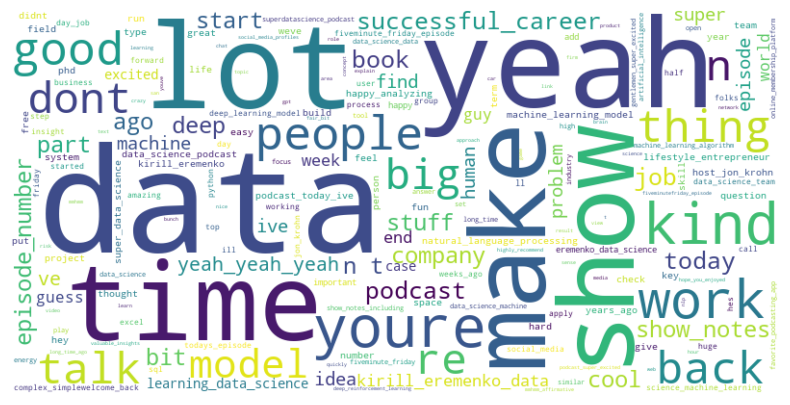

In [49]:

all_keywords = ' '.join(keywords_per_class.Document)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

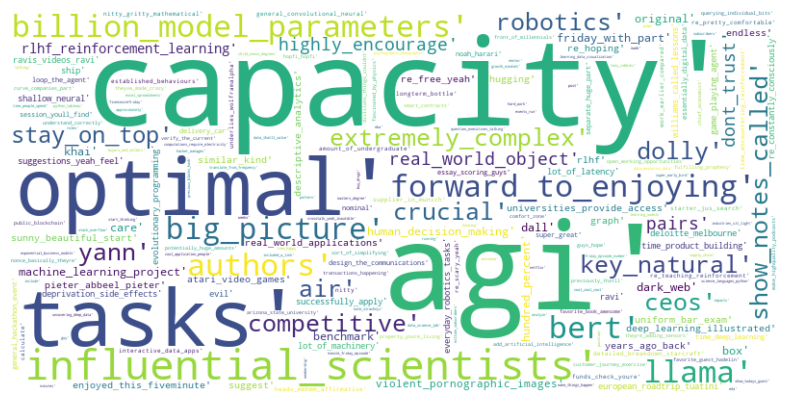

In [51]:
all_keywords = ' '.join(map(str, class_unique_50.unique_Words))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [61]:
sds_ds_bert = pd.read_csv('../data/sds_ds_keywords.csv')

<IPython.core.display.Javascript object>

In [62]:
sds_ds_bert["episode_keywords"] = None
sds_ds_bert["keywords"] = None

In [63]:
sds_ds_bert

,episode_number,episode_name,length_episode,class,guest_name,host_episode,episode_year,episode_date,episode_split_text,episode_keywords,keywords
0,1,"Ruben Kogel on Self-Serve Analytics, R vs Pyt...",42,Database,Ruben Kogel,Kirill Eremenko,2016,2016-09-10,this is episode number one with exchemical eng...,None,None
1,2,"Machine Learning, Recommender Systems and the...",51,Machine Learning,Hadelin de Ponteves,Kirill Eremenko,2016,2016-09-14,this is session number two with machine learni...,None,None
2,3,"Defining the Data Problem, Data Science in Ma...",53,Machine Learning,Dr. Wilson Pok,Kirill Eremenko,2016,2016-09-25,this is episode number three with nanophysics ...,None,None
3,4,"Data and Strategy, three Pillars of Research ...",60,Data Science,Brendan Hogan,Kirill Eremenko,2016,2016-10-02,this is episode four with business strategy ex...,None,None
4,5,"Computer Forensics, Fraud Analytics and knowi...",63,Data Science,Dmitry Korneev,Kirill Eremenko,2016,2016-10-09,this is episode number five with forensics inv...,None,None
...,...,...,...,...,...,...,...,...,...,...,...
446,679,"The A.I. and Machine Learning Landscape, with...",94,Artificial Intelligence,George Mathew,Jon Krohn,2023,2023-05-16,this is episode number with george matthew ma...,None,None
447,680,Automating Industrial Machines with Data Scie...,30,Data Science,Allegra Alessi,Jon Krohn,2023,2023-05-19,this is episode number with allegra alessi io...,None,None
448,681,XGBoost,72,Machine Learning,Matt Harrison,Jon Krohn,2023,2023-05-23,this is episode number with matt harrison man...,None,None
449,682,"Business Intelligence Tools, with Mico Yuk",28,Data Science,Mico Yuk,Jon Krohn,2023,2023-05-26,this is episode number with mico yuk host of ...,None,None


In [ ]:
def bert_keyword_extractor(doc):
    kw_model = KeyBERT()
    global sds_ds_bet
    stopwords = list(STOP_WORDS)
    
    for i, episode_text in doc.iteritems():
        keywords = kw_model.extract_keywords(episode_text, keyphrase_ngram_range=(1, 3), stop_words = stopwords, top_n = 100, use_mmr=True, diversity=0.7)
        s.at[i, 'episode_keywords'] = keywords

In [ ]:
bert_keyword_extractor(sds_ds_processed['episode_split_text'])

In [ ]:
# https://maartengr.github.io/BERTopic/index.html